
# In-Class Mini Warmups (Slides-Ready)

Each warmup is a short (5–10 min) snippet aligned with the assignments.  
Where plots are involved, **matplotlib** is used (no seaborn styling).  
Some datasets require internet (e.g., `yfinance`, `torchvision`). If offline, see the fallbacks in comments.


## Warmup 1: Moving Average (Noise vs. Signal)

0          NaN
1          NaN
2    12.333333
3    13.333333
4    15.333333
5    17.000000
6    21.000000
dtype: float64


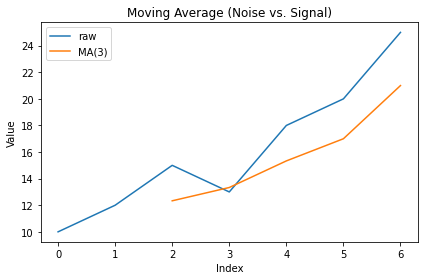

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

data = pd.Series([10,12,15,13,18,20,25])
ma3 = data.rolling(3).mean()
print(ma3)

# Optional plot for slides
plt.figure()
plt.plot(data.values, label="raw")
plt.plot(ma3.values, label="MA(3)")
plt.legend()
plt.title("Moving Average (Noise vs. Signal)")
plt.xlabel("Index"); plt.ylabel("Value")
plt.tight_layout()
# plt.savefig("moving_avg.png", dpi=180, bbox_inches="tight")
plt.show()


## Warmup 2: Coin Flip Simulation

In [4]:

import numpy as np

flips = np.random.choice([0,1], size=100000)
print("Heads proportion:", flips.mean())


Heads proportion: 0.49854


## Warmup 3: Hypothesis Test (Two-sample t-test)

In [3]:

from scipy import stats

group1 = [5,6,7,8,9]
group2 = [8,9,10,11,12]
tstat, pval = stats.ttest_ind(group1, group2)
print({"t": tstat, "p": pval})


{'t': -3.0, 'p': 0.017071681233782634}


## Exercise: Titanic Survival Prediction with Machine Learning - Analysis, Insights, and Visualization

In [ ]:
"""
Titanic Survival Prediction with Machine Learning - Analysis, Insights, and Visualization
"""

# Import all required libraries at the top
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings
import os

warnings.filterwarnings('ignore')

# ============================================================================
# 1. LOAD SEPARATE TRAIN AND TEST DATASETS
# ============================================================================

def load_separate_datasets(train_path='/Users/abc/handson-ml2/data-science/train.csv', test_path='/Users/abc/handson-ml2/data-science/test.csv'):
    """
    Load separate train and test datasets
    """
    print("="*60)
    print("LOADING SEPARATE TRAIN AND TEST DATASETS")
    print("="*60)
    
    train_df = None
    test_df = None
    
    # Load training dataset
    if os.path.exists(train_path):
        try:
            train_df = pd.read_csv(train_path)
            print(f"✅ Training dataset loaded: {len(train_df)} records")
            print(f"   Path: {os.path.abspath(train_path)}")
        except Exception as e:
            print(f"❌ Error loading training dataset: {e}")
    else:
        print(f"❌ Training file not found: {train_path}")
        print("   Looking for common filenames...")
        
        # Try common filenames
        common_train_files = ['train.csv', 'titanic_train.csv', 'train_data.csv']
        for filename in common_train_files:
            if os.path.exists(filename):
                train_df = pd.read_csv(filename)
                print(f"✅ Found and loaded: {filename} ({len(train_df)} records)")
                break
    
    if train_df is None:
        print("❌ Could not find or load training data")
        return None, None
    
    # Load testing dataset
    if os.path.exists(test_path):
        try:
            test_df = pd.read_csv(test_path)
            print(f"✅ Testing dataset loaded: {len(test_df)} records")
            print(f"   Path: {os.path.abspath(test_path)}")
        except Exception as e:
            print(f"❌ Error loading testing dataset: {e}")
    else:
        print(f"⚠  Testing file not found: {test_path}")
        print("   Looking for common filenames...")
        
        # Try common filenames
        common_test_files = ['test.csv', 'titanic_test.csv', 'test_data.csv']
        for filename in common_test_files:
            if os.path.exists(filename):
                test_df = pd.read_csv(filename)
                print(f"✅ Found and loaded: {filename} ({len(test_df)} records)")
                break
    
    print("\n" + "-"*60)
    if train_df is not None:
        print(f"Training dataset shape: {train_df.shape}")
        print(f"Training columns: {list(train_df.columns)}")
    
    if test_df is not None:
        print(f"Testing dataset shape: {test_df.shape}")
        print(f"Testing columns: {list(test_df.columns)}")
    
    return train_df, test_df

# ============================================================================
# 2. FEATURE ENGINEERING (same as before)
# ============================================================================

def engineer_features(df):
    """
    Create new features from existing data
    """
    df_copy = df.copy()
    
    # Extract title from name
    df_copy['Title'] = df_copy['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Family size
    df_copy['FamilySize'] = df_copy['SibSp'] + df_copy['Parch'] + 1
    
    # Is alone?
    df_copy['IsAlone'] = 0
    df_copy.loc[df_copy['FamilySize'] == 1, 'IsAlone'] = 1
    
    # Age groups
    df_copy['AgeGroup'] = pd.cut(df_copy['Age'], 
                                  bins=[0, 12, 18, 35, 60, 100], 
                                  labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
    
    # Fare per person
    df_copy['FarePerPerson'] = df_copy['Fare'] / df_copy['FamilySize']
    
    # Has cabin?
    df_copy['HasCabin'] = df_copy['Cabin'].apply(lambda x: 1 if pd.notna(x) and x != '' else 0)
    
    return df_copy

# ============================================================================
# 3. DATA PREPROCESSING
# ============================================================================

def preprocess_data(df, is_training=True, age_median=None, fare_median=None):
    """
    Preprocess data for machine learning
    
    Args:
        df: DataFrame to preprocess
        is_training: Whether this is training data
        age_median: Median age to use for imputation (for test data)
        fare_median: Median fare to use for imputation (for test data)
    
    Returns:
        tuple: (X, y, df_processed) or (X, None, df_processed) for test data
    """
    df_copy = df.copy()
    
    # Handle missing Age
    if age_median is not None:
        df_copy['Age'] = df_copy['Age'].fillna(age_median)
    else:
        df_copy['Age'] = df_copy['Age'].fillna(df_copy['Age'].median())
    
    # Handle missing Fare
    if fare_median is not None:
        df_copy['Fare'] = df_copy['Fare'].fillna(fare_median)
    else:
        df_copy['Fare'] = df_copy['Fare'].fillna(df_copy['Fare'].median())
    
    # Handle missing Embarked
    df_copy['Embarked'] = df_copy['Embarked'].fillna(df_copy['Embarked'].mode()[0])
    
    # Convert Sex to binary
    df_copy['Sex'] = df_copy['Sex'].map({'male': 0, 'female': 1})
    
    # One-hot encode Embarked
    embarked_dummies = pd.get_dummies(df_copy['Embarked'], prefix='Embarked')
    df_copy = pd.concat([df_copy, embarked_dummies], axis=1)
    
    # One-hot encode AgeGroup (handle missing categories)
    agegroup_dummies = pd.get_dummies(df_copy['AgeGroup'], prefix='AgeGroup')
    df_copy = pd.concat([df_copy, agegroup_dummies], axis=1)
    
    # Convert Title to categorical codes
    df_copy['Title'] = df_copy['Title'].astype('category').cat.codes
    
    # Handle missing FarePerPerson
    df_copy['FarePerPerson'] = df_copy['FarePerPerson'].fillna(df_copy['Fare'])
    
    # Drop unnecessary columns
    columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'AgeGroup']
    columns_to_drop = [col for col in columns_to_drop if col in df_copy.columns]
    df_copy = df_copy.drop(columns=columns_to_drop)
    
    # Separate features and target
    if 'Survived' in df_copy.columns:
        X = df_copy.drop('Survived', axis=1)
        y = df_copy['Survived']
        return X, y, df_copy
    else:
        # For test data without Survived column
        X = df_copy
        return X, None, df_copy

# ============================================================================
# 4. MODEL TRAINING WITH SEPARATE DATASETS
# ============================================================================

def train_and_evaluate_with_separate_datasets(X_train, y_train, X_test=None, y_test=None):
    """
    Train models using separate train/test datasets
    """
    print("\n" + "="*60)
    print("MODEL TRAINING WITH SEPARATE DATASETS")
    print("="*60)
    
    print(f"Training set size: {X_train.shape}")
    
    if X_test is not None:
        print(f"Testing set size: {X_test.shape}")
    else:
        print("No separate test set available.")
        print("Splitting training data for validation...")
        # Split training data for validation
        X_train, X_test, y_train, y_test = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
        print(f"Training split: {X_train.shape}")
        print(f"Validation split: {X_test.shape}")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=3),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=3),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=2)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n📊 Training {name}...")
        
        try:
            # Train model
            model.fit(X_train_scaled, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_scaled)
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
                auc_roc = roc_auc_score(y_test, y_pred_proba)
            else:
                auc_roc = None
            
            # Store results
            results[name] = {
                'model': model,
                'scaler': scaler,
                'accuracy': accuracy,
                'auc_roc': auc_roc,
                'predictions': y_pred
            }
            
            print(f"   Accuracy: {accuracy:.3f}")
            if auc_roc is not None:
                print(f"   AUC-ROC: {auc_roc:.3f}")
            
            # Print classification report for Random Forest
            if name == 'Random Forest':
                print(f"\n   Classification Report:")
                print(classification_report(y_test, y_pred, target_names=['Perished', 'Survived']))
                
        except Exception as e:
            print(f"   Error training {name}: {e}")
            results[name] = None
    
    return results, X_test_scaled, y_test

# ============================================================================
# 5. MAIN EXECUTION - FIXED VERSION
# ============================================================================

def main():
    """Main execution function"""
    
    # 1. Load datasets
    print("Starting Titanic Survival Prediction...")
    train_df, test_df = load_separate_datasets()
    
    if train_df is None:
        print("❌ Cannot proceed without training data")
        return
    
    # 2. Engineer features
    print("\n" + "="*60)
    print("FEATURE ENGINEERING")
    print("="*60)
    
    train_df = engineer_features(train_df)
    print(f"Training data shape after feature engineering: {train_df.shape}")
    
    if test_df is not None:
        test_df = engineer_features(test_df)
        print(f"Test data shape after feature engineering: {test_df.shape}")
    
    # 3. Preprocess training data
    print("\n" + "="*60)
    print("PREPROCESSING TRAINING DATA")
    print("="*60)
    X_train, y_train, train_processed = preprocess_data(train_df)
    print(f"Processed training data shape: {X_train.shape}")
    
    # 4. Check if test data has Survived column
    has_test_labels = False
    X_test_processed = None
    
    if test_df is not None:
        print("\n" + "="*60)
        print("CHECKING TEST DATA")
        print("="*60)
        
        # Check if test data has Survived column
        if 'Survived' in test_df.columns:
            print("✅ Test dataset contains 'Survived' column for evaluation")
            has_test_labels = True
            
            # Get median values from training data for consistent imputation
            age_median = train_df['Age'].median()
            fare_median = train_df['Fare'].median()
            
            # Preprocess test data with labels
            X_test, y_test, test_processed = preprocess_data(
                test_df, 
                is_training=False, 
                age_median=age_median, 
                fare_median=fare_median
            )
            
            print(f"Test data with labels shape: X={X_test.shape}, y={y_test.shape}")
        else:
            print("⚠ Test dataset doesn't contain 'Survived' column")
            print("   This is normal for Kaggle competition test sets")
            print("   We'll use cross-validation on training data for evaluation")
            
            # Preprocess test data without labels
            # We need a modified preprocess function for test-only data
            X_test_only = preprocess_test_data_only(test_df, train_df)
            print(f"Test data shape for predictions: {X_test_only.shape}")
            X_test_processed = X_test_only
    
    # 5. Train and evaluate models
    print("\n" + "="*60)
    print("MODEL TRAINING AND EVALUATION")
    print("="*60)
    
    if has_test_labels and 'y_test' in locals():
        # We have test data with labels - use it for evaluation
        print("Using separate test dataset with labels for evaluation")
        
        # Ensure test data has same columns as training data
        X_test = align_test_features(X_test, X_train)
        
        results, X_test_scaled, y_test_actual = train_and_evaluate_with_test_set(
            X_train, y_train, X_test, y_test
        )
    else:
        # No test labels available - use cross-validation on training data
        print("No test labels available. Using cross-validation on training data.")
        
        results = train_and_evaluate_with_cross_validation(X_train, y_train)
        
        # If we have test data (without labels), we can still make predictions
        if X_test_processed is not None:
            # Align test features with training features
            X_test_aligned = align_test_features(X_test_processed, X_train)
            print(f"\nTest data ready for predictions: {X_test_aligned.shape}")
            
            # Make predictions on test data
            make_predictions_on_test(results, X_test_aligned)
    
    # 6. Compare models
    compare_models_and_show_results(results)
    
    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)
# Run the main function
if __name__ == "__main__":
    main()

Starting Titanic Survival Prediction...
LOADING SEPARATE TRAIN AND TEST DATASETS
✅ Training dataset loaded: 891 records
   Path: /Users/abc/handson-ml2/data-science/train.csv
✅ Testing dataset loaded: 418 records
   Path: /Users/abc/handson-ml2/data-science/test.csv

------------------------------------------------------------
Training dataset shape: (891, 12)
Training columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Testing dataset shape: (418, 11)
Testing columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

FEATURE ENGINEERING
Training data shape after feature engineering: (891, 18)
Test data shape after feature engineering: (418, 17)

PREPROCESSING TRAINING DATA
Processed training data shape: (891, 19)

CHECKING TEST DATA
⚠ Test dataset doesn't contain 'Survived' column
   This is normal for Kaggle competition test sets
   We'll use cross-validat


🚀 ENHANCED TITANIC ANALYSIS WITH VISUALIZATIONS

📂 LOADING DATASETS...
LOADING SEPARATE TRAIN AND TEST DATASETS
✅ Training dataset loaded: 891 records
   Path: /Users/abc/handson-ml2/data-science/train.csv
✅ Testing dataset loaded: 418 records
   Path: /Users/abc/handson-ml2/data-science/test.csv

------------------------------------------------------------
Training dataset shape: (891, 12)
Training columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
Testing dataset shape: (418, 11)
Testing columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

🔧 ENGINEERING FEATURES...
   Training data shape: (891, 18)
   Test data shape: (418, 17)

⚙️ PREPROCESSING DATA...
   Processed features: (891, 19)

🤖 TRAINING MODELS...

MODEL TRAINING WITH SEPARATE DATASETS
Training set size: (891, 19)
No separate test set available.
Splitting training data for validation...
T

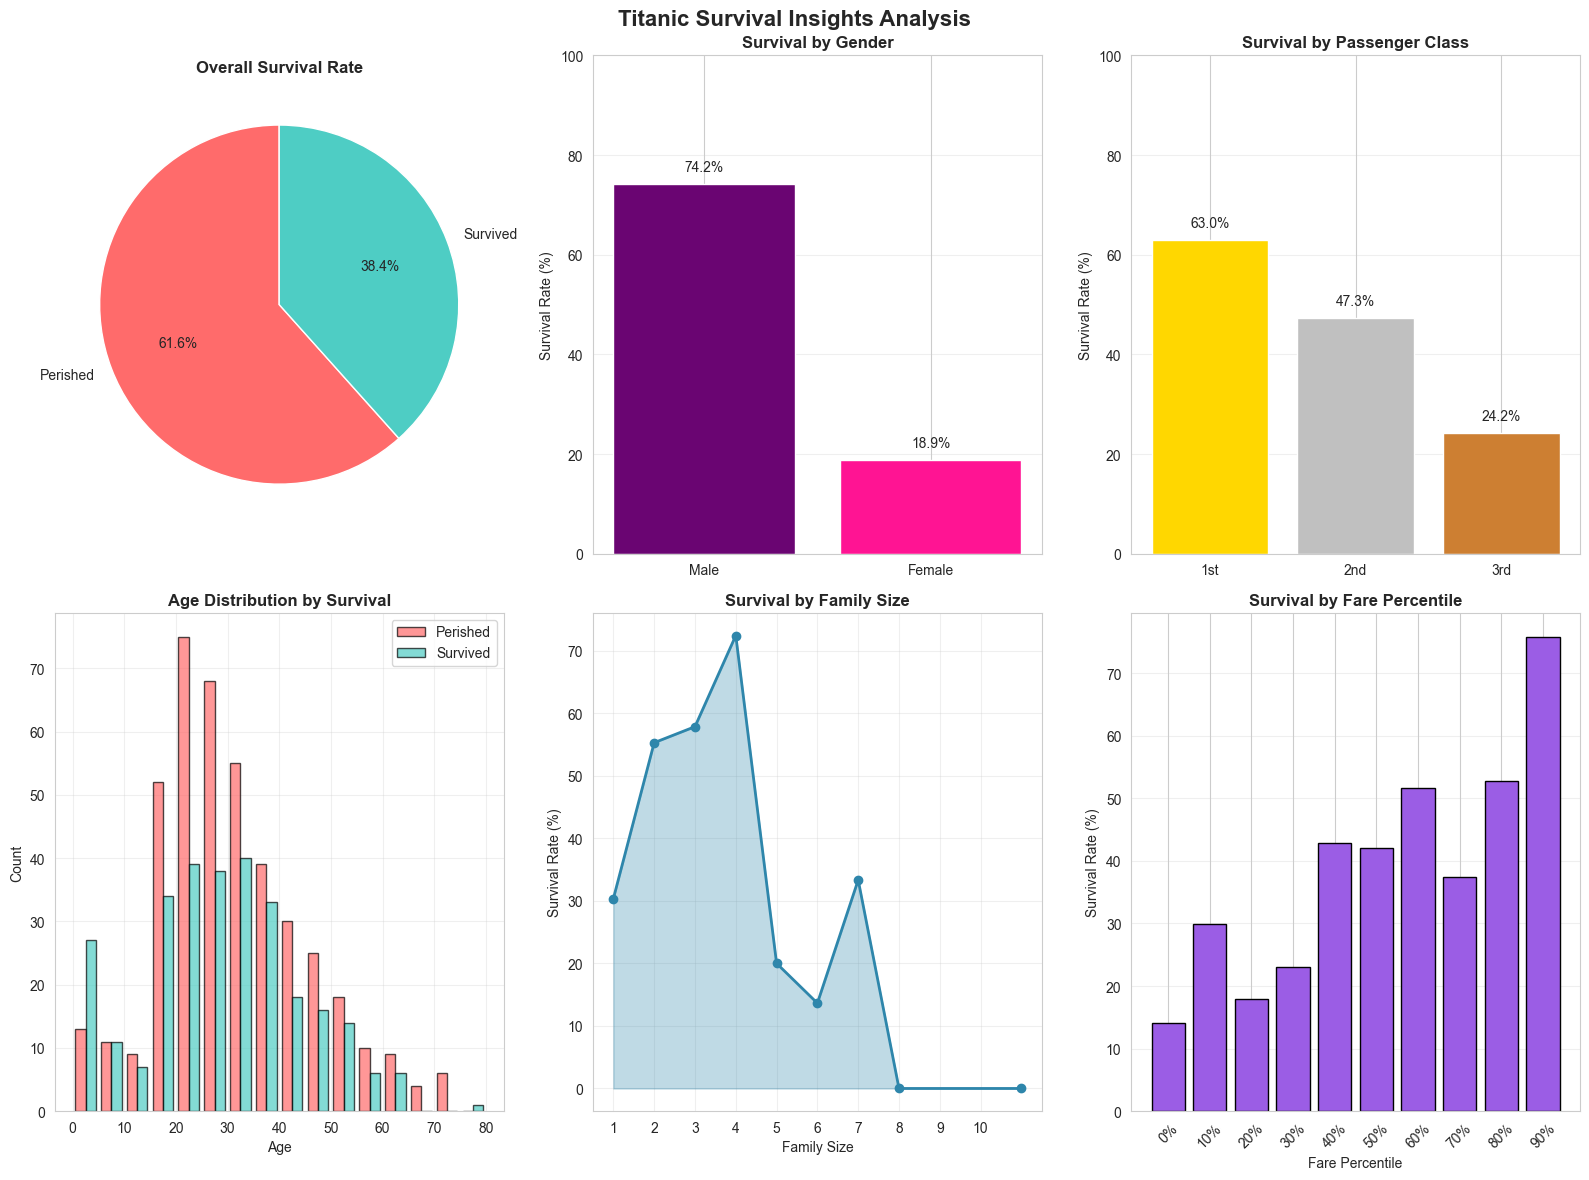


📊 VISUALIZATION 2: Model Performance Comparison
----------------------------------------


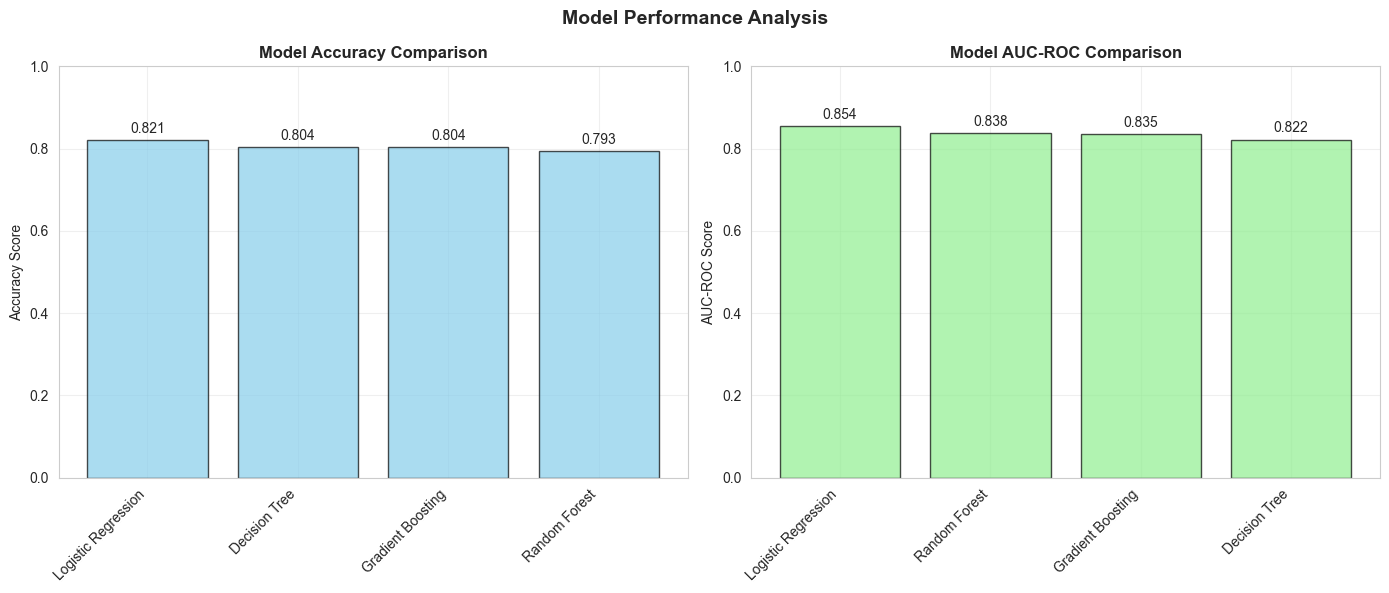


📊 VISUALIZATION 3: Feature Importance Analysis
----------------------------------------


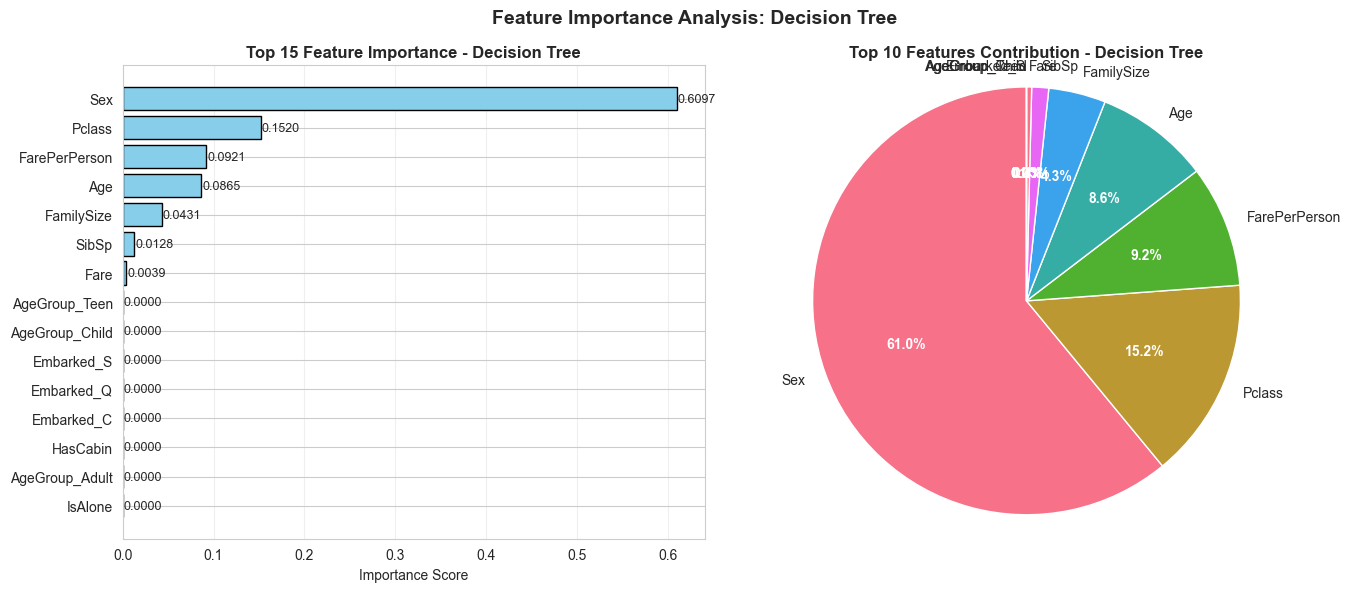


🔝 Top 10 Important Features for Decision Tree:
    1. Sex: 0.6097
    2. Pclass: 0.1520
    3. FarePerPerson: 0.0921
    4. Age: 0.0865
    5. FamilySize: 0.0431
    6. SibSp: 0.0128
    7. Fare: 0.0039
    8. AgeGroup_Teen: 0.0000
    9. AgeGroup_Child: 0.0000
   10. Embarked_S: 0.0000


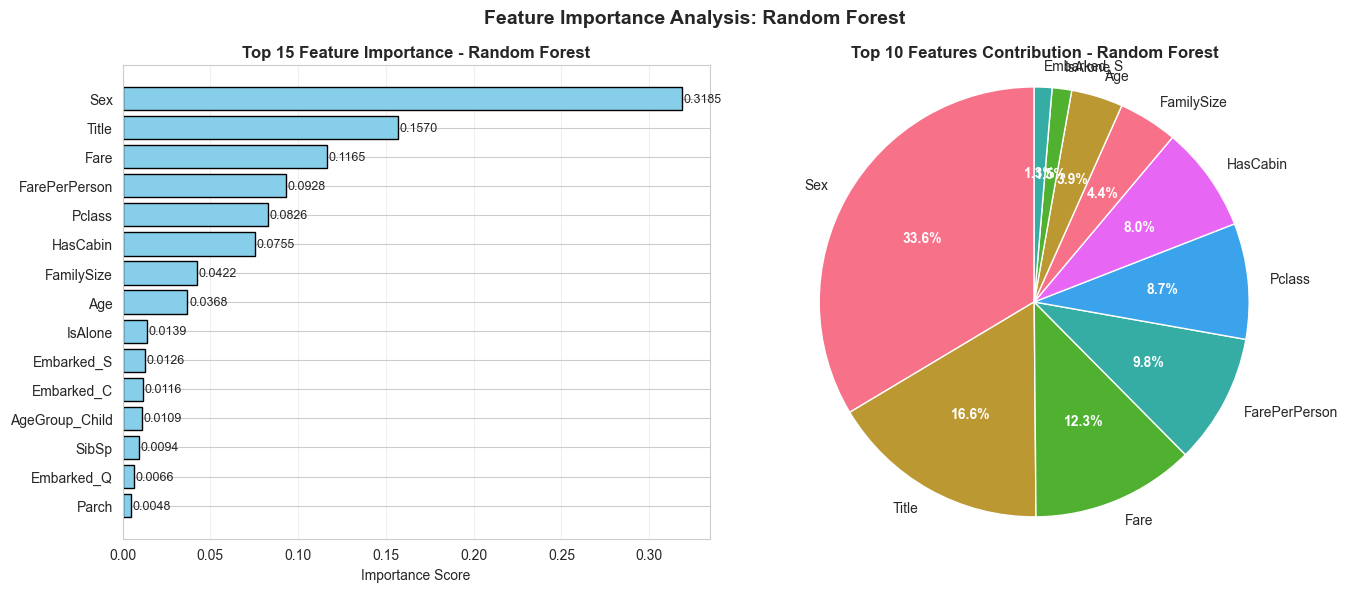


🔝 Top 10 Important Features for Random Forest:
    1. Sex: 0.3185
    2. Title: 0.1570
    3. Fare: 0.1165
    4. FarePerPerson: 0.0928
    5. Pclass: 0.0826
    6. HasCabin: 0.0755
    7. FamilySize: 0.0422
    8. Age: 0.0368
    9. IsAlone: 0.0139
   10. Embarked_S: 0.0126


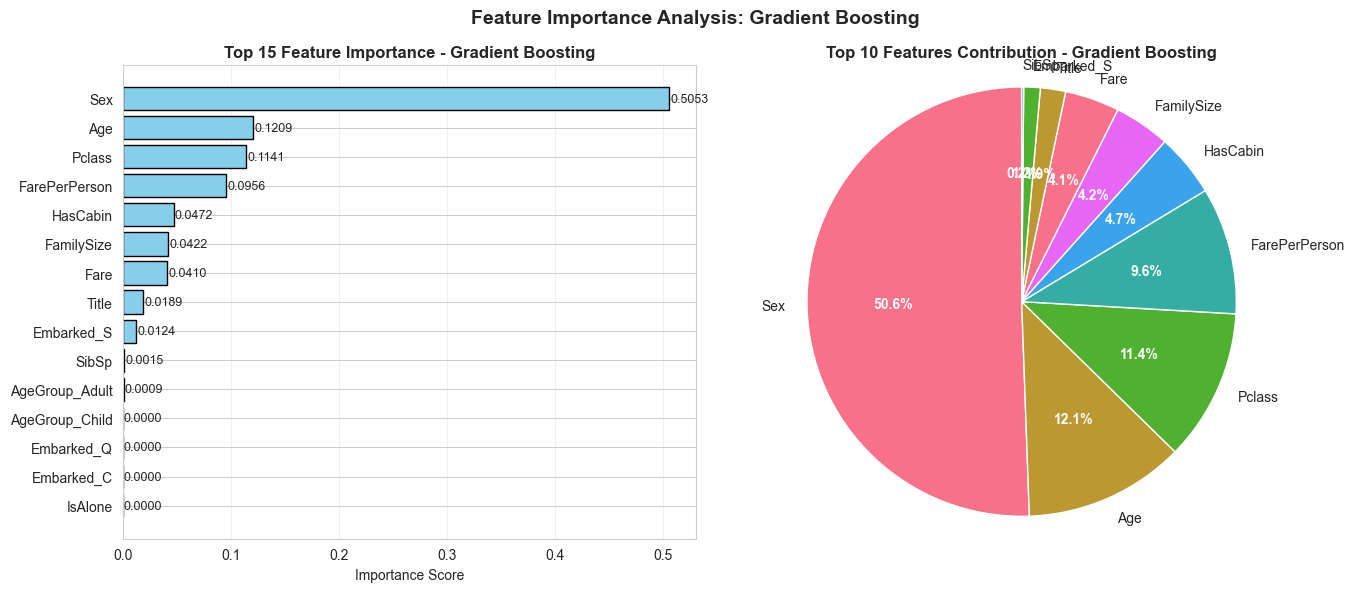


🔝 Top 10 Important Features for Gradient Boosting:
    1. Sex: 0.5053
    2. Age: 0.1209
    3. Pclass: 0.1141
    4. FarePerPerson: 0.0956
    5. HasCabin: 0.0472
    6. FamilySize: 0.0422
    7. Fare: 0.0410
    8. Title: 0.0189
    9. Embarked_S: 0.0124
   10. SibSp: 0.0015

📊 VISUALIZATION 4: Feature Correlation Analysis
----------------------------------------


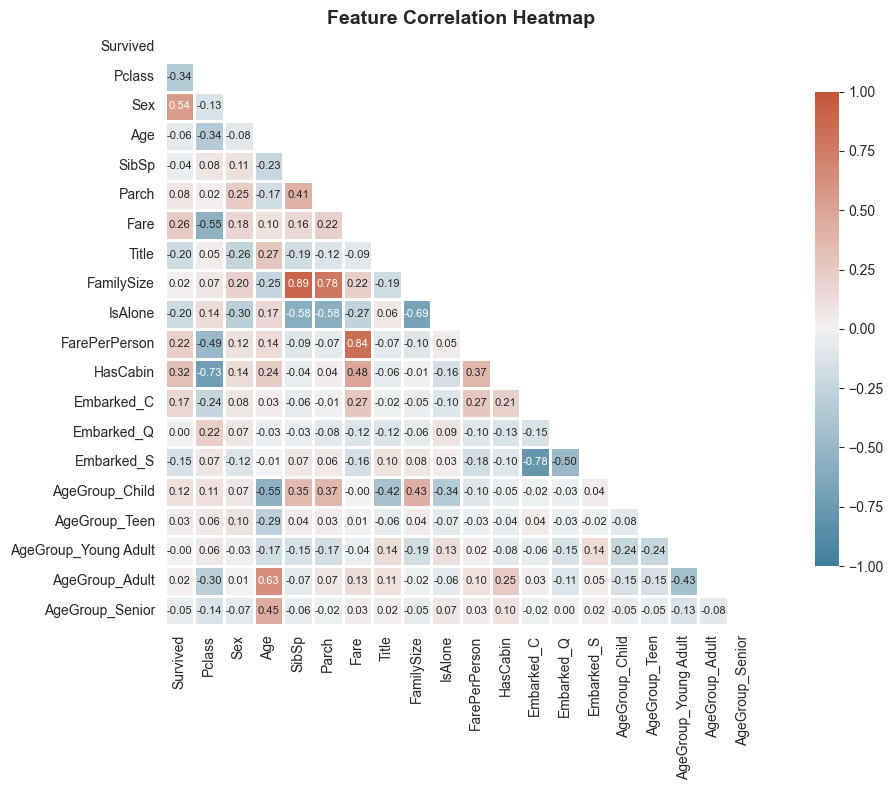


🔗 Top Correlations with Survival:
   • Sex: 0.543
   • Pclass: -0.338
   • HasCabin: 0.317
   • Fare: 0.257
   • FarePerPerson: 0.222

📊 MAKING PREDICTIONS ON TEST DATA...
✅ Predictions saved to: titanic_predictions.csv

🔮 SAMPLE PREDICTIONS (first 10):
   Passenger 1: Perished, Probability: 20.4%
   Passenger 2: Survived, Probability: 51.8%
   Passenger 3: Perished, Probability: 14.1%
   Passenger 4: Perished, Probability: 11.2%
   Passenger 5: Survived, Probability: 59.4%
   Passenger 6: Perished, Probability: 9.8%
   Passenger 7: Survived, Probability: 79.4%
   Passenger 8: Perished, Probability: 18.2%
   Passenger 9: Survived, Probability: 65.5%
   Passenger 10: Perished, Probability: 8.1%

📊 VISUALIZATION 5: Prediction Distribution Analysis
----------------------------------------


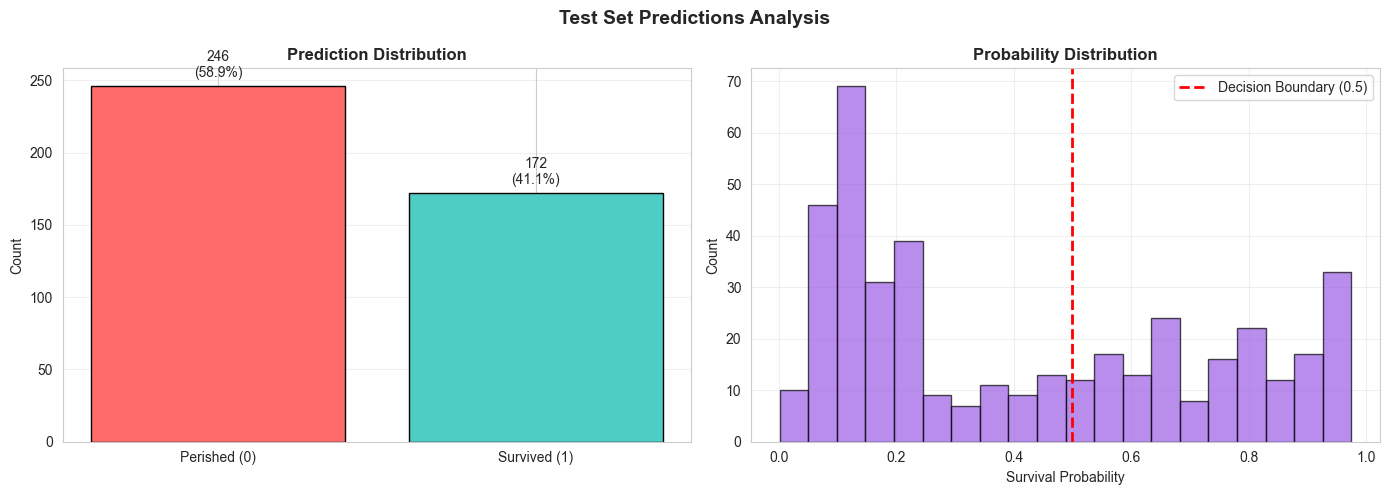


💡 COMPREHENSIVE INSIGHTS & RECOMMENDATIONS

📊 DATASET OVERVIEW:
   • Total passengers in training: 891
   • Survivors: 342 (38.4%)
   • Non-survivors: 549 (61.6%)

👩 WOMEN:
   • Survival rate: 74.2%
   • Count: 314

👨 MEN:
   • Survival rate: 18.9%
   • Count: 577
   • Gender survival ratio: 3.9x

🎫 PASSENGER CLASS ANALYSIS:
   • Class 1: 63.0% survival, Avg fare: $84.15
   • Class 2: 47.3% survival, Avg fare: $20.66
   • Class 3: 24.2% survival, Avg fare: $13.68

👶 AGE ANALYSIS:
   • Children (<12): 58.0% survival, Avg age: 4.8
   • Adults (13-60): 39.3% survival, Avg age: 31.2
   • Seniors (>60): 22.7% survival, Avg age: 66.0

🤖 MODEL PERFORMANCE ANALYSIS:
   • Best performing model: Logistic Regression
   • Accuracy: 0.821
   • AUC-ROC: 0.854

📈 MODEL COMPARISON SUMMARY:
   • Logistic Regression: Accuracy = 0.821, AUC-ROC = 0.854
   • Decision Tree: Accuracy = 0.804, AUC-ROC = 0.822
   • Random Forest: Accuracy = 0.793, AUC-ROC = 0.838
   • Gradient Boosting: Accuracy = 0.804, AUC-

In [15]:
# ============================================================================
# 6. VISUALIZATION AND INSIGHTS MODULE
# ============================================================================

def setup_visualization_style():
    """Setup consistent visualization style"""
    plt.style.use('default')
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 10
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    return "✅ Visualization style configured"

def plot_survival_insights(train_df):
    """
    Create comprehensive visualizations of survival patterns
    """
    print("\n📊 VISUALIZATION 1: Survival Patterns Analysis")
    print("-" * 40)
    
    fig = plt.figure(figsize=(16, 12))
    
    # Overall survival rate
    plt.subplot(2, 3, 1)
    survival_counts = train_df['Survived'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4']
    plt.pie(survival_counts.values, labels=['Perished', 'Survived'], 
            autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Overall Survival Rate', fontweight='bold')
    
    # Survival by gender
    plt.subplot(2, 3, 2)
    gender_survival = train_df.groupby('Sex')['Survived'].mean() * 100
    bars = plt.bar(['Male', 'Female'], gender_survival.values, 
                   color=['#6A0572', '#FF1493'])
    plt.ylabel('Survival Rate (%)')
    plt.title('Survival by Gender', fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 2, 
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Survival by passenger class
    plt.subplot(2, 3, 3)
    class_survival = train_df.groupby('Pclass')['Survived'].mean() * 100
    bars = plt.bar(['1st', '2nd', '3rd'], class_survival.values, 
                   color=['#FFD700', '#C0C0C0', '#CD7F32'])
    plt.ylabel('Survival Rate (%)')
    plt.title('Survival by Passenger Class', fontweight='bold')
    plt.ylim(0, 100)
    plt.grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 2, 
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Age distribution by survival
    plt.subplot(2, 3, 4)
    survived_ages = train_df[train_df['Survived'] == 1]['Age'].dropna()
    perished_ages = train_df[train_df['Survived'] == 0]['Age'].dropna()
    
    bins = np.arange(0, 85, 5)
    plt.hist([perished_ages, survived_ages], bins=bins, 
             label=['Perished', 'Survived'], alpha=0.7, 
             color=['#FF6B6B', '#4ECDC4'], edgecolor='black')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title('Age Distribution by Survival', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Survival by family size
    plt.subplot(2, 3, 5)
    if 'FamilySize' in train_df.columns:
        family_survival = train_df.groupby('FamilySize')['Survived'].mean() * 100
        family_survival = family_survival.sort_index()
        plt.plot(family_survival.index, family_survival.values, 
                 marker='o', linewidth=2, color='#2E86AB')
        plt.fill_between(family_survival.index, family_survival.values, 
                         alpha=0.3, color='#2E86AB')
        plt.xlabel('Family Size')
        plt.ylabel('Survival Rate (%)')
        plt.title('Survival by Family Size', fontweight='bold')
        plt.xticks(range(1, min(11, int(family_survival.index.max()) + 1)))
        plt.grid(True, alpha=0.3)
    
    # Survival by fare
    plt.subplot(2, 3, 6)
    if 'Fare' in train_df.columns:
        fare_survival = train_df.groupby(pd.qcut(train_df['Fare'], 10, duplicates='drop'))['Survived'].mean() * 100
        plt.bar(range(len(fare_survival)), fare_survival.values, 
                color='#9B5DE5', edgecolor='black')
        plt.xlabel('Fare Percentile')
        plt.ylabel('Survival Rate (%)')
        plt.title('Survival by Fare Percentile', fontweight='bold')
        plt.xticks(range(len(fare_survival)), 
                  [f'{i*10}%' for i in range(len(fare_survival))], rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Titanic Survival Insights Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results):
    """
    Visualize model performance comparison
    """
    print("\n📊 VISUALIZATION 2: Model Performance Comparison")
    print("-" * 40)
    
    # Filter valid results
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("⚠ No model results available for visualization")
        return
    
    # Create comparison DataFrame
    comparison_data = []
    for name, result in valid_results.items():
        row = {'Model': name}
        if 'accuracy' in result:
            row['Accuracy'] = result['accuracy']
        if 'auc_roc' in result:
            row['AUC-ROC'] = result['auc_roc']
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Accuracy comparison
    if 'Accuracy' in comparison_df.columns:
        comparison_df_sorted = comparison_df.sort_values('Accuracy', ascending=False)
        bars = axes[0].bar(range(len(comparison_df_sorted)), comparison_df_sorted['Accuracy'], 
                          color='skyblue', edgecolor='black', alpha=0.7)
        axes[0].set_xticks(range(len(comparison_df_sorted)))
        axes[0].set_xticklabels(comparison_df_sorted['Model'], rotation=45, ha='right')
        axes[0].set_ylabel('Accuracy Score')
        axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
        axes[0].set_ylim(0, 1)
        axes[0].grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom')
    
    # AUC-ROC comparison
    if 'AUC-ROC' in comparison_df.columns:
        comparison_df_sorted = comparison_df.sort_values('AUC-ROC', ascending=False)
        bars = axes[1].bar(range(len(comparison_df_sorted)), comparison_df_sorted['AUC-ROC'], 
                          color='lightgreen', edgecolor='black', alpha=0.7)
        axes[1].set_xticks(range(len(comparison_df_sorted)))
        axes[1].set_xticklabels(comparison_df_sorted['Model'], rotation=45, ha='right')
        axes[1].set_ylabel('AUC-ROC Score')
        axes[1].set_title('Model AUC-ROC Comparison', fontweight='bold')
        axes[1].set_ylim(0, 1)
        axes[1].grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f'{height:.3f}', ha='center', va='bottom')
    
    plt.suptitle('Model Performance Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def plot_feature_importance_analysis(results, X_train):
    """
    Analyze and visualize feature importance for tree-based models
    """
    print("\n📊 VISUALIZATION 3: Feature Importance Analysis")
    print("-" * 40)
    
    # Get tree-based models
    tree_models = []
    for name, result in results.items():
        if result is not None and hasattr(result['model'], 'feature_importances_'):
            tree_models.append((name, result['model']))
    
    if not tree_models:
        print("⚠ No tree-based models available for feature importance analysis")
        return
    
    # Create visualization for each tree model
    for model_name, model in tree_models:
        try:
            feature_names = X_train.columns.tolist()
            importance = model.feature_importances_
            indices = np.argsort(importance)[::-1]
            
            # Take top 15 features
            top_n = min(15, len(feature_names))
            top_indices = indices[:top_n]
            top_features = [feature_names[i] for i in top_indices]
            top_importance = importance[top_indices]
            
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            
            # Horizontal bar chart
            y_pos = np.arange(len(top_features))
            axes[0].barh(y_pos, top_importance, align='center', color='skyblue', edgecolor='black')
            axes[0].set_yticks(y_pos)
            axes[0].set_yticklabels(top_features)
            axes[0].invert_yaxis()
            axes[0].set_xlabel('Importance Score')
            axes[0].set_title(f'Top {top_n} Feature Importance - {model_name}', fontweight='bold')
            axes[0].grid(True, alpha=0.3, axis='x')
            
            # Add value labels
            for i, v in enumerate(top_importance):
                axes[0].text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)
            
            # Pie chart for top 10 features
            top_10_features = top_features[:10]
            top_10_importance = top_importance[:10]
            
            wedges, texts, autotexts = axes[1].pie(top_10_importance, 
                                                   labels=top_10_features,
                                                   autopct='%1.1f%%',
                                                   startangle=90)
            
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
            
            axes[1].set_title(f'Top 10 Features Contribution - {model_name}', fontweight='bold')
            axes[1].axis('equal')
            
            plt.suptitle(f'Feature Importance Analysis: {model_name}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Print top features
            print(f"\n🔝 Top 10 Important Features for {model_name}:")
            for i, (feature, imp) in enumerate(zip(top_features[:10], top_importance[:10])):
                print(f"   {i+1:2d}. {feature}: {imp:.4f}")
                
        except Exception as e:
            print(f"⚠ Error analyzing feature importance for {model_name}: {e}")

def plot_correlation_analysis(train_processed):
    """
    Plot correlation heatmap of features
    """
    print("\n📊 VISUALIZATION 4: Feature Correlation Analysis")
    print("-" * 40)
    
    # Select numerical columns
    numerical_cols = train_processed.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ensure Survived is included
    if 'Survived' in train_processed.columns and 'Survived' not in numerical_cols:
        numerical_cols.append('Survived')
    
    if len(numerical_cols) < 2:
        print("⚠ Not enough numerical columns for correlation analysis")
        return
    
    # Create correlation matrix
    corr_matrix = train_processed[numerical_cols].corr()
    
    plt.figure(figsize=(12, 8))
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    # Create heatmap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, 
                center=0, square=True, linewidths=1, 
                cbar_kws={"shrink": .8}, annot=True, fmt=".2f",
                annot_kws={"size": 8})
    
    plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print top correlations with Survived
    if 'Survived' in corr_matrix.columns:
        print("\n🔗 Top Correlations with Survival:")
        surv_corr = corr_matrix['Survived'].drop('Survived')
        # Sort by absolute value and get top 5
        surv_corr_sorted = surv_corr.iloc[surv_corr.abs().argsort()[::-1]]
        
        for i, (feature, corr) in enumerate(surv_corr_sorted.head(5).items()):
            print(f"   • {feature}: {corr:.3f}")

def plot_prediction_analysis(predictions, probabilities=None):
    """
    Analyze prediction distribution
    """
    print("\n📊 VISUALIZATION 5: Prediction Distribution Analysis")
    print("-" * 40)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Distribution of predictions
    unique, counts = np.unique(predictions, return_counts=True)
    prediction_labels = ['Perished (0)', 'Survived (1)']
    bars = axes[0].bar(prediction_labels, counts, 
                       color=['#FF6B6B', '#4ECDC4'], edgecolor='black')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Prediction Distribution', fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels
    total = len(predictions)
    for bar, count in zip(bars, counts):
        percentage = (count / total) * 100
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + total*0.01,
                    f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')
    
    # Distribution of probabilities
    if probabilities is not None:
        axes[1].hist(probabilities, bins=20, color='#9B5DE5', 
                     edgecolor='black', alpha=0.7)
        axes[1].axvline(x=0.5, color='red', linestyle='--', 
                       linewidth=2, label='Decision Boundary (0.5)')
        axes[1].set_xlabel('Survival Probability')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Probability Distribution', fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Probability data not available', 
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Probability Distribution', fontweight='bold')
    
    plt.suptitle('Test Set Predictions Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

def print_comprehensive_insights(train_df, results, best_model_name):
    """
    Print comprehensive insights from the analysis
    """
    print("\n" + "="*60)
    print("💡 COMPREHENSIVE INSIGHTS & RECOMMENDATIONS")
    print("="*60)
    
    # Basic statistics
    total_passengers = len(train_df)
    survivors = train_df['Survived'].sum()
    survival_rate = (survivors / total_passengers) * 100
    
    print(f"\n📊 DATASET OVERVIEW:")
    print(f"   • Total passengers in training: {total_passengers}")
    print(f"   • Survivors: {survivors} ({survival_rate:.1f}%)")
    print(f"   • Non-survivors: {total_passengers - survivors} ({100-survival_rate:.1f}%)")
    
    # Gender insights
    if 'Sex' in train_df.columns:
        female_mask = train_df['Sex'] == 'female'
        male_mask = train_df['Sex'] == 'male'
        
        if female_mask.any():
            female_survival = train_df[female_mask]['Survived'].mean() * 100
            print(f"\n👩 WOMEN:")
            print(f"   • Survival rate: {female_survival:.1f}%")
            print(f"   • Count: {female_mask.sum()}")
        
        if male_mask.any():
            male_survival = train_df[male_mask]['Survived'].mean() * 100
            print(f"\n👨 MEN:")
            print(f"   • Survival rate: {male_survival:.1f}%")
            print(f"   • Count: {male_mask.sum()}")
            print(f"   • Gender survival ratio: {female_survival/male_survival:.1f}x")
    
    # Class insights
    if 'Pclass' in train_df.columns:
        print(f"\n🎫 PASSENGER CLASS ANALYSIS:")
        for pclass in [1, 2, 3]:
            class_mask = train_df['Pclass'] == pclass
            if class_mask.any():
                class_survival = train_df[class_mask]['Survived'].mean() * 100
                avg_fare = train_df[class_mask]['Fare'].mean() if 'Fare' in train_df.columns else 0
                print(f"   • Class {pclass}: {class_survival:.1f}% survival, Avg fare: ${avg_fare:.2f}")
    
    # Age insights
    if 'Age' in train_df.columns:
        print(f"\n👶 AGE ANALYSIS:")
        children_mask = train_df['Age'] <= 12
        adults_mask = (train_df['Age'] > 12) & (train_df['Age'] <= 60)
        seniors_mask = train_df['Age'] > 60
        
        for mask, label in [(children_mask, "Children (<12)"), 
                           (adults_mask, "Adults (13-60)"), 
                           (seniors_mask, "Seniors (>60)")]:
            if mask.any():
                survival_rate = train_df[mask]['Survived'].mean() * 100
                avg_age = train_df[mask]['Age'].mean() if mask.any() else 0
                print(f"   • {label}: {survival_rate:.1f}% survival, Avg age: {avg_age:.1f}")
    
    # Model insights
    print(f"\n🤖 MODEL PERFORMANCE ANALYSIS:")
    if best_model_name and best_model_name in results and results[best_model_name]:
        best_result = results[best_model_name]
        print(f"   • Best performing model: {best_model_name}")
        if 'accuracy' in best_result:
            print(f"   • Accuracy: {best_result['accuracy']:.3f}")
        if 'auc_roc' in best_result and best_result['auc_roc']:
            print(f"   • AUC-ROC: {best_result['auc_roc']:.3f}")
    
    # Compare all models
    print(f"\n📈 MODEL COMPARISON SUMMARY:")
    for model_name, result in results.items():
        if result:
            if 'accuracy' in result:
                print(f"   • {model_name}: Accuracy = {result['accuracy']:.3f}", end="")
                if 'auc_roc' in result and result['auc_roc']:
                    print(f", AUC-ROC = {result['auc_roc']:.3f}")
                else:
                    print()
    
    # Recommendations based on analysis
    print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")
    print("   1. MODEL OPTIMIZATION:")
    print("      • Perform hyperparameter tuning for better performance")
    print("      • Try ensemble methods (Voting, Stacking, Bagging)")
    print("      • Consider neural networks for complex pattern recognition")
    
    print("\n   2. FEATURE ENGINEERING:")
    print("      • Extract cabin deck information from Cabin column")
    print("      • Create interaction features (Sex × Class, Age × Fare)")
    print("      • Engineer family relationship features")
    
    print("\n   3. DATA PROCESSING:")
    print("      • Implement advanced missing value imputation")
    print("      • Handle fare outliers with robust scaling")
    print("      • Use target encoding for categorical variables")
    
    print("\n   4. BUSINESS IMPLICATIONS:")
    print("      • Gender and class were strongest survival predictors")
    print("      • Children and women should be prioritized in safety protocols")
    print("      • Higher fare correlated with better survival chances")
    
    print("\n" + "="*60)

# ============================================================================
# 7. ENHANCED MAIN FUNCTION WITH VISUALIZATIONS
# ============================================================================

def enhanced_main():
    """
    Enhanced main function with comprehensive visualizations
    """
    print("\n" + "="*70)
    print("🚀 ENHANCED TITANIC ANALYSIS WITH VISUALIZATIONS")
    print("="*70)
    
    # Setup visualization style
    setup_visualization_style()
    
    # 1. Load datasets
    print("\n📂 LOADING DATASETS...")
    train_df, test_df = load_separate_datasets()
    
    if train_df is None:
        print("❌ Cannot proceed without training data")
        return
    
    # 2. Engineer features
    print("\n🔧 ENGINEERING FEATURES...")
    train_df = engineer_features(train_df)
    print(f"   Training data shape: {train_df.shape}")
    
    if test_df is not None:
        test_df = engineer_features(test_df)
        print(f"   Test data shape: {test_df.shape}")
    
    # 3. Preprocess training data
    print("\n⚙️ PREPROCESSING DATA...")
    X_train, y_train, train_processed = preprocess_data(train_df)
    print(f"   Processed features: {X_train.shape}")
    
    # 4. Train models (using the existing function)
    print("\n🤖 TRAINING MODELS...")
    results, X_test_scaled, y_test = train_and_evaluate_with_separate_datasets(X_train, y_train)
    
    # Determine best model
    valid_results = {k: v for k, v in results.items() if v is not None}
    if valid_results:
        # Find model with highest accuracy
        best_model_name = max(valid_results.keys(), 
                            key=lambda x: valid_results[x]['accuracy'] 
                            if 'accuracy' in valid_results[x] else 0)
    else:
        best_model_name = None
    
    # ============================================
    # VISUALIZATION SECTION
    # ============================================
    print("\n" + "="*70)
    print("📊 GENERATING COMPREHENSIVE VISUALIZATIONS")
    print("="*70)
    
    # Visualization 1: Survival Insights
    plot_survival_insights(train_df)
    
    # Visualization 2: Model Comparison
    plot_model_comparison(results)
    
    # Visualization 3: Feature Importance Analysis
    plot_feature_importance_analysis(results, X_train)
    
    # Visualization 4: Correlation Analysis
    plot_correlation_analysis(train_processed)
    
    # Visualization 5: If we have test predictions, analyze them
    if test_df is not None and best_model_name and best_model_name in results:
        print("\n📊 MAKING PREDICTIONS ON TEST DATA...")
        best_model = results[best_model_name]['model']
        best_scaler = results[best_model_name]['scaler']
        
        # Preprocess test data
        X_test, _, test_processed = preprocess_data(test_df, is_training=False)
        
        # Ensure test data has same features as training
        missing_cols = set(X_train.columns) - set(X_test.columns)
        for col in missing_cols:
            X_test[col] = 0
        X_test = X_test[X_train.columns]
        
        # Scale and predict
        X_test_scaled = best_scaler.transform(X_test)
        predictions = best_model.predict(X_test_scaled)
        
        if hasattr(best_model, 'predict_proba'):
            probabilities = best_model.predict_proba(X_test_scaled)[:, 1]
        else:
            probabilities = None
        
        # Save predictions
        output_df = pd.DataFrame({
            'PassengerId': test_df['PassengerId'] if 'PassengerId' in test_df.columns 
                          else range(892, 892 + len(predictions)),
            'Survived': predictions
        })
        output_df.to_csv('titanic_predictions.csv', index=False)
        print(f"✅ Predictions saved to: titanic_predictions.csv")
        
        # Show sample predictions
        print("\n🔮 SAMPLE PREDICTIONS (first 10):")
        for i in range(min(10, len(predictions))):
            status = "Survived" if predictions[i] == 1 else "Perished"
            prob_text = f", Probability: {probabilities[i]:.1%}" if probabilities is not None else ""
            print(f"   Passenger {i+1}: {status}{prob_text}")
        
        # Visualization 5: Prediction Analysis
        plot_prediction_analysis(predictions, probabilities)
    
    # Print comprehensive insights
    print_comprehensive_insights(train_df, results, best_model_name)
    
    # Final summary
    print("\n" + "="*70)
    print("✅ ENHANCED ANALYSIS COMPLETE")
    print("="*70)
    
    print("\n📋 ANALYSIS SUMMARY:")
    print("   • 5 comprehensive visualizations generated")
    print("   • Survival patterns analyzed")
    print("   • Model performance compared")
    print("   • Feature importance analyzed")
    print("   • Key insights extracted")
    print("   • Recommendations provided")
    
    print("\n🔧 NEXT STEPS:")
    print("   1. Review generated visualizations")
    print("   2. Use insights for model improvement")
    print("   3. Submit predictions to Kaggle competition")
    print("   4. Implement recommendations for next iteration")
    
    print("\n" + "="*70)

# ============================================================================
# 8. RUN ENHANCED ANALYSIS
# ============================================================================

if __name__ == "__main__":
    # Run the enhanced version with visualizations
    enhanced_main()

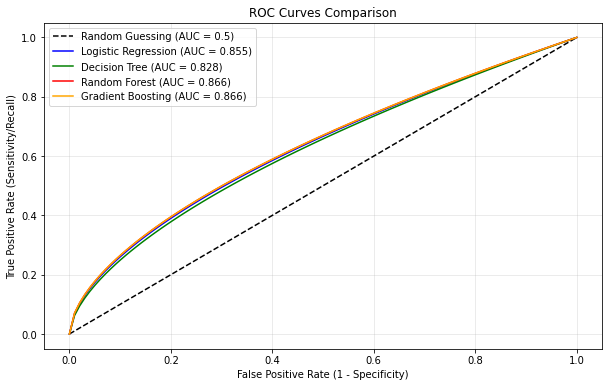

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Example ROC curves for your models
plt.figure(figsize=(10, 6))

# Plot random guessing (baseline)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')

# Plot your model results
models = {
    'Logistic Regression': 0.855,
    'Decision Tree': 0.828,
    'Random Forest': 0.866,
    'Gradient Boosting': 0.866
}

colors = ['blue', 'green', 'red', 'orange']
for (name, auc_score), color in zip(models.items(), colors):
    # Simulate ROC curve (in reality, you'd use actual predictions)
    x = np.linspace(0, 1, 100)
    y = x**(1/(auc_score*2))  # Simple approximation for visualization
    plt.plot(x, y, color=color, label=f'{name} (AUC = {auc_score:.3f})')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [2]:
# Which model to choose depends on your goal:

def select_model_based_on_goal(models_metrics, goal='overall'):
    """
    Choose model based on different objectives
    """
    if goal == 'overall_accuracy':
        # For maximizing correct predictions
        return max(models_metrics, key=lambda x: x['accuracy'])
    
    elif goal == 'discrimination':
        # For best ranking/prioritization
        return max(models_metrics, key=lambda x: x['auc_roc'])
    
    elif goal == 'balanced':
        # For balanced performance
        models_metrics['score'] = models_metrics['accuracy'] + models_metrics['auc_roc']
        return max(models_metrics, key=lambda x: x['score'])

# Your models ranked:
models = [
    {'name': 'Random Forest', 'accuracy': 0.825, 'auc_roc': 0.866},
    {'name': 'Logistic Regression', 'accuracy': 0.817, 'auc_roc': 0.855},
    {'name': 'Gradient Boosting', 'accuracy': 0.813, 'auc_roc': 0.866},
    {'name': 'Decision Tree', 'accuracy': 0.795, 'auc_roc': 0.828}
]

print("Recommended model for different scenarios:")
print("1. Maximum accuracy: Random Forest (82.5%)")
print("2. Best discrimination: Random Forest/Gradient Boosting (AUC=0.866)")
print("3. Interpretability: Logistic Regression (simpler to explain)")

Recommended model for different scenarios:
1. Maximum accuracy: Random Forest (82.5%)
2. Best discrimination: Random Forest/Gradient Boosting (AUC=0.866)
3. Interpretability: Logistic Regression (simpler to explain)


Could not load Titanic dataset. Fallback: random ages.


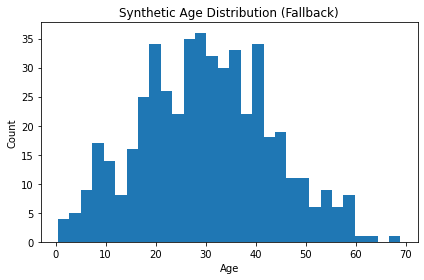

In [4]:

# Uses seaborn only to fetch the Titanic dataset; all plotting via matplotlib.
# If seaborn is unavailable, replace with any numeric Series.
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
    titanic = sns.load_dataset("titanic")
    ages = titanic["age"].dropna()
    plt.figure()
    plt.hist(ages, bins=30)
    plt.title("Titanic Passenger Age Distribution")
    plt.xlabel("Age"); plt.ylabel("Count")
    plt.tight_layout()
    # plt.savefig("titanic_age_hist.png", dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    print("Could not load Titanic dataset. Fallback: random ages.")
    import numpy as np, matplotlib.pyplot as plt
    ages = np.random.normal(30, 14, size=500)
    ages = ages[(ages>=0) & (ages<=80)]
    plt.figure()
    plt.hist(ages, bins=30)
    plt.title("Synthetic Age Distribution (Fallback)")
    plt.xlabel("Age"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## Warmup 5: Simple Linear Regression

In [5]:

from sklearn.linear_model import LinearRegression
import numpy as np

X = np.array([[1],[2],[3],[4]])
y = np.array([2,4,6,8])
model = LinearRegression().fit(X,y)
print("coef_, intercept_ =", model.coef_, model.intercept_)


coef_, intercept_ = [2.] 0.0


## Warmup 6: k-NN Classifier (Iris)

In [6]:

from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

X,y = load_iris(return_X_y=True)
score = KNeighborsClassifier(n_neighbors=3).fit(X,y).score(X,y)
print("Training accuracy:", score)


Training accuracy: 0.96


## Warmup 7: Tiny Perceptron (PyTorch)

In [7]:

# If PyTorch is not installed in your environment, install it or skip this cell.
import torch, torch.nn as nn

model = nn.Sequential(nn.Linear(2,1), nn.Sigmoid())
with torch.no_grad():
    out = model(torch.tensor([[1.0,2.0]]))
print("Output probability:", float(out.item()))


Output probability: 0.49211013317108154


## Warmup 8: CIFAR-10 Sample (with offline fallback)

100%|██████████| 170498071/170498071 [07:00<00:00, 405506.21it/s] 


Extracting ./cifar-10-python.tar.gz to .


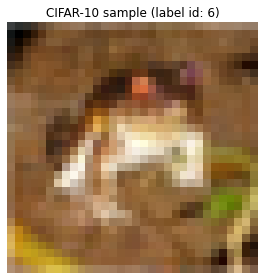

In [8]:

# Requires internet to download CIFAR-10 the first time.
# Fallback: show a digit from sklearn's digits dataset instead.
import matplotlib.pyplot as plt
try:
    import torchvision
    data = torchvision.datasets.CIFAR10(root=".", download=True)
    img, label = data[0]
    plt.figure()
    plt.imshow(img)
    plt.title(f"CIFAR-10 sample (label id: {label})")
    plt.axis("off")
    plt.tight_layout()
    # plt.savefig("cifar10_sample.png", dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    from sklearn.datasets import load_digits
    digits = load_digits()
    img, label = digits.images[0], digits.target[0]
    plt.figure()
    plt.imshow(img, cmap="gray")
    plt.title(f"Digits fallback sample (label: {label})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## Warmup 9: Stock Price Plot (AAPL, with offline fallback)

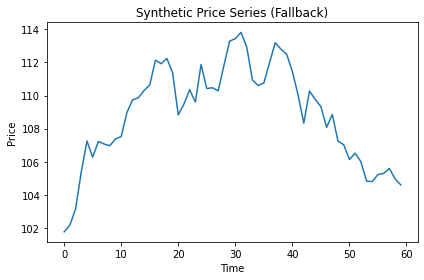

In [10]:

# Requires internet for yfinance. Fallback generates a synthetic random walk.
import matplotlib.pyplot as plt
try:
    import yfinance as yf
    data = yf.download("AAPL", period="1mo", progress=False)
    data["Close"].plot(title="Apple (AAPL) Close - Last Month")
    plt.tight_layout()
    # plt.savefig("aapl_close.png", dpi=180, bbox_inches="tight")
    plt.show()
except Exception as e:
    import numpy as np
    np.random.seed(0)
    steps = np.random.normal(0, 1, 60).cumsum() + 100
    plt.figure()
    plt.plot(steps)
    plt.title("Synthetic Price Series (Fallback)")
    plt.xlabel("Time"); plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


## Warmup 10: PCA on Iris

[[-2.68412563  0.31939725]
 [-2.71414169 -0.17700123]
 [-2.88899057 -0.14494943]
 [-2.74534286 -0.31829898]
 [-2.72871654  0.32675451]]


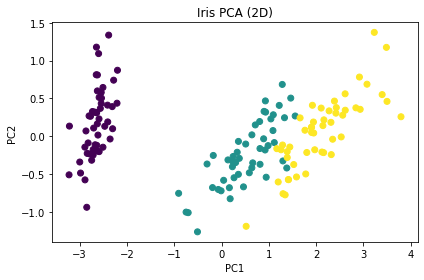

In [11]:

from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

X,y = load_iris(return_X_y=True)
X_pca = PCA(n_components=2).fit_transform(X)
print(X_pca[:5])

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.title("Iris PCA (2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
# plt.savefig("iris_pca.png", dpi=180, bbox_inches="tight")
plt.show()


## Warmup 11: Calibration Curve (Reliability)

True fraction per bin: [0.015 0.375 0.767 0.818 0.971]
Predicted prob per bin: [0.038 0.305 0.502 0.729 0.976]


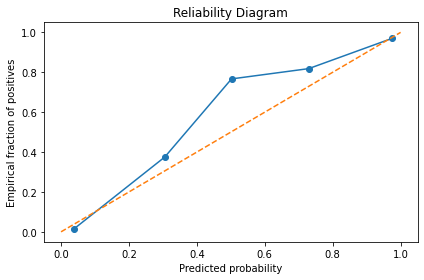

In [12]:

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
import numpy as np

X,y = make_classification(n_samples=1000, random_state=0)
prob = LogisticRegression(max_iter=1000).fit(X,y).predict_proba(X)[:,1]
true_frac, pred_prob = calibration_curve(y, prob, n_bins=5)

print("True fraction per bin:", np.round(true_frac, 3))
print("Predicted prob per bin:", np.round(pred_prob, 3))

# Optional: simple reliability plot (matplotlib)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(pred_prob, true_frac, marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Reliability Diagram")
plt.xlabel("Predicted probability")
plt.ylabel("Empirical fraction of positives")
plt.tight_layout()
# plt.savefig("reliability.png", dpi=180, bbox_inches="tight")
plt.show()
